# Dimentionality Reduction using PHATE

Prerequisites:
- You have preprocessed your data in the AnnData format into the data/preprocessed directory. [notebook: 0-data-preprocessing]: 
    - gene values on _X_ (adata.X)
    - phate embeddings of the data on _obsm_ (ex.: adata.obsm['X_phate])
    - any extra metadata on _obs_ (ex.: adata.obs['time'], adata.obs['disease_progression'], etc...)


In this notebook, we will:
- Use the preprocessed data to create a comntinuous latent space.
- This space will be created by running PHATE
- We will show how to interpret some of the phate parameters and how to choose a good representation of the space.

In [1]:
import phate
import scprep
import meld
import pandas as pd
import scanpy as sc

In [2]:
data_path = '/vast/palmer/pi/krishnaswamy_smita/John_Lock_STranscriptomics_2024/DN48_Output_Table_20241008.parquet'

In [3]:
df = pd.read_parquet(data_path)

In [4]:
# Read the columns of interest from the text file
interest_columns = '../../../interest_columns/upperquartile_intensity_columns.txt'
with open(interest_columns, 'r') as file:
    columns_of_interest = [line.strip() for line in file]

In [5]:
# Randomly sample 20000 rows
df = df.sample(n=20000, random_state=42)

In [6]:
# Filter the DataFrame to keep only the columns in the text file
df_filtered = df[df.columns.intersection(columns_of_interest)]
df_filtered = df_filtered.dropna()
df_filtered.shape

(20000, 66)

In [7]:
#Drop metadata related columns
df_processed = df_filtered.drop(['Cellprof_Metadata_Well_ID','Metadata_Field','EM_Class','CC_Class','006_Metadata_Treatment'],axis=1)
df_processed.shape

(20000, 61)

In [8]:
# Drop rows with missing values
df_processed = df_processed.dropna()
# Drop columns with missing values
df_processed = df_processed.dropna(axis=1)
#Drop cols with unique values
df_processed = df_processed.loc[:, df_processed.nunique() > 1]
df_processed.shape


(20000, 61)

In [9]:
cell_class = df_filtered['EM_Class']
time_label = df_filtered['006_Metadata_Treatment']
cell_cycle_label = df_filtered['CC_Class']
cell_class.shape

(20000,)

<Axes: xlabel='Library size', ylabel='Number of cells'>

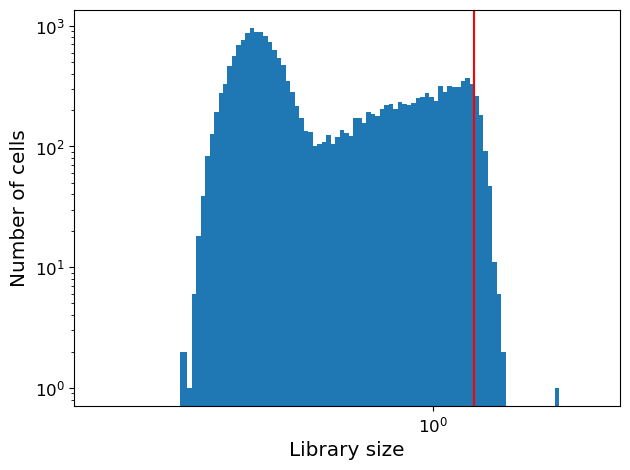

In [10]:
percentile = 97
scprep.plot.plot_library_size(df_processed, percentile=percentile)

In [11]:
#Need to pass the cell_class so the labels will be maintained when removing cells.

df_phate,cell_class = scprep.filter.filter_library_size(df_processed, sample_labels= cell_class, percentile=percentile, keep_cells='below')
df_phate,time_label = scprep.filter.filter_library_size(df_processed, sample_labels= time_label, percentile=percentile, keep_cells='below')
df_phate,cell_cycle_label = scprep.filter.filter_library_size(df_processed, sample_labels= cell_cycle_label, percentile=percentile, keep_cells='below')


df_phate.shape

(19400, 61)

In [12]:
df_phate = scprep.filter.filter_rare_genes(df_phate, min_cells=10000)
df_phate = scprep.normalize.library_size_normalize(df_phate)
df_phate.shape

(19400, 60)

# Creating the AnnData Object

In [13]:
obs_df = pd.DataFrame({
    'time_label': time_label,
    'cell_class': cell_class,
    'cell_cycle_label' : cell_cycle_label
})

In [14]:
adata_emt = sc.AnnData(X=df_phate,obs=obs_df)

/vast/palmer/pi/krishnaswamy_smita/jcr222/conda/conda_envs/emp_project/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
adata_emt

AnnData object with n_obs × n_vars = 19400 × 60
    obs: 'time_label', 'cell_class', 'cell_cycle_label'

In [16]:
pca_df = sc.pp.pca(adata_emt, n_comps=50)

In [17]:
phate_op = phate.PHATE(n_components=3)
X_phate = phate_op.fit_transform(adata_emt.obsm['X_pca'])

Calculating PHATE...
  Running PHATE on 19400 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 19.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 19.21 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.96 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.36 seconds.
  Calculated landmark operator in 5.08 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 1.29 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.53 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.31 seconds.
Calculated PHATE in 36.44 seconds.


In [18]:
adata_emt.obs['time_label']

index
80694    168_hour
68936     6_hours
72480     6_hours
33311    72_hours
48598      60_min
           ...   
40329      20_min
220         0_min
38388      20_min
72235     6_hours
31188       5_min
Name: time_label, Length: 19400, dtype: object

In [19]:
from matplotlib.cm import viridis
categories = ['0_min', '2_min', '5_min', '20_min', '60_min', '3_hours', '6_hours', '24_hours', '72_hours', '120_hours', '168_hour']

# Create a mapping between categories and colors from viridis
# This controls the order of colors
num_categories = len(categories)
ordered_cmap = {cat: viridis(i/num_categories) for i, cat in enumerate(categories)}


<Axes: >

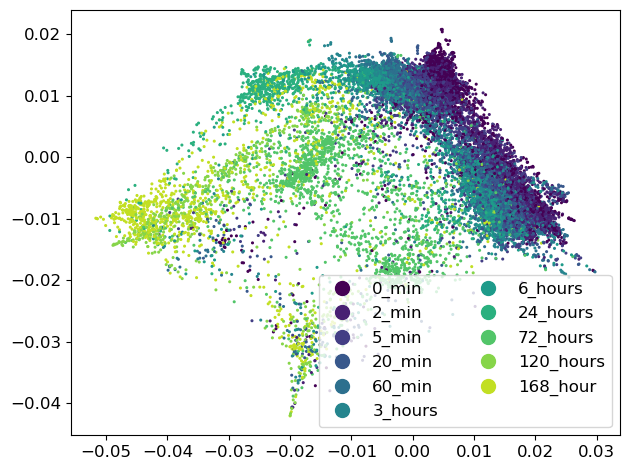

In [20]:
scprep.plot.scatter2d(X_phate, c=adata_emt.obs['time_label'], cmap=ordered_cmap)

In [21]:
# binary_time = time_label.isin(['0_min', '2_min', '5_min', '20_min', '60_min', '3_hours'])
binary_time = time_label.isin(['0_min', '2_min', '5_min', '20_min', '60_min', '3_hours','6_hours'])


<Axes: >

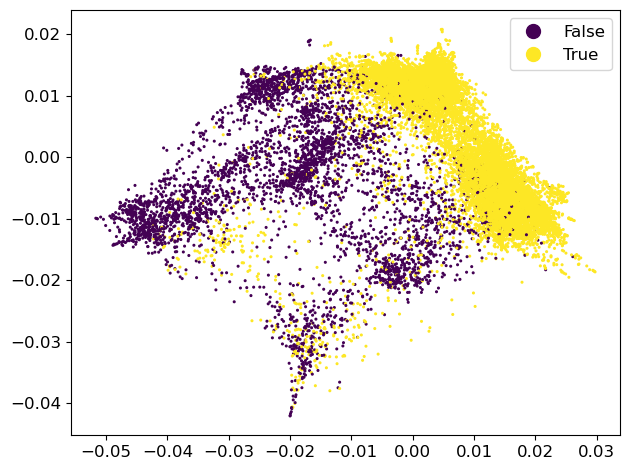

In [22]:
scprep.plot.scatter2d(X_phate, c=binary_time, cmap='viridis')

In [23]:
meld_op = meld.MELD()
sample_densities = meld_op.fit_transform(X_phate, sample_labels=binary_time)
chd_likelihood = meld.normalize_densities(sample_densities)

Building graph on 19400 samples and 3 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.49 seconds.
  Calculating affinities...
  Calculated affinities in 0.06 seconds.
Calculated graph and diffusion operator in 0.77 seconds.


<Axes: >

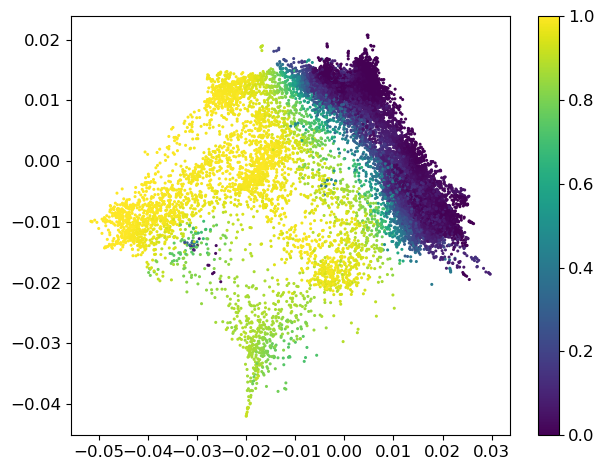

In [24]:
scprep.plot.scatter2d(X_phate, c=chd_likelihood[False], cmap='viridis')

In [41]:
!ls ../../../

 0.000-jfr-Time-specific-PHATE.ipynb	       'Feature Descriptions.txt'
 0.00-jfr-old_PHATE.ipynb		        figures
 0.01-jfr-Median-Intensity-PHATE.ipynb	        generate_phate_plots.py
'0.02-jfr-Mean-Intensity-PHATE copy.ipynb'      generate_phate_plots.sh
 0.04-jfr-UpperQuartile-Intensity-PHATE.ipynb   gwas_ritini
 all_columns.txt			        interest_columns
 data					        logs
 data_main				        phate_columns.txt
 emt_notebooks				        selected_columns.txt


In [38]:
adata_emt.obs['meld_likelihood'] = chd_likelihood[False].to_numpy()


adata_emt.write('../../../data/adata_emt_meld.h5ad')